In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../geometry') 
from pyMesh import hcubeMesh, visualize2D, plotBC, plotMesh,setAxisLabel

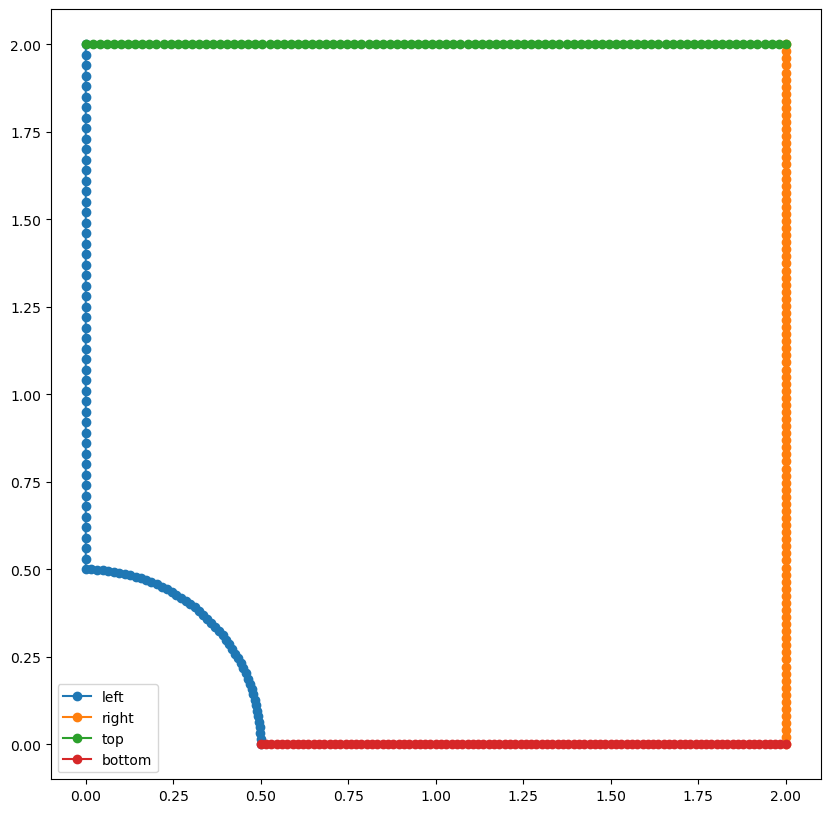

In [2]:
#define geometry

L = 2.0
R = 0.5
O = [0.0, 0.0]

n_point = 100

theta = 0

leftX_1 = R*np.cos(np.linspace(theta, np.pi/2+theta, int(n_point/2))) + O[0]
leftX_2 = np.zeros(int(n_point/2)+1)
leftX = np.concatenate((leftX_1, leftX_2[1:]))

leftY_1 = R*np.sin(np.linspace(theta, np.pi/2+theta, int(n_point/2))) + O[1]
leftY_2 = np.linspace(R, L, int(n_point/2)+1)
leftY = np.concatenate((leftY_1, leftY_2[1:]))

rightX = np.ones(n_point)*L
# rightY = leftY
rightY = np.linspace(0, L, n_point)

upX = np.linspace(0, L, n_point)
upY = np.ones(n_point)*L

lowX = np.linspace(R,L,n_point)
lowY = np.zeros(n_point)


fig, ax = plt.subplots(1, 1,figsize=(10,10))
plt.plot(leftX, leftY, marker='o', label='left')
plt.plot(rightX, rightY, marker='o', label='right')
plt.plot(upX, upY, marker='o', label='top')
plt.plot(lowX, lowY, marker='o', label='bottom')

ax.set_aspect('equal')
plt.legend()



In [3]:
h=0.01

myMesh=hcubeMesh(leftX,leftY,rightX,rightY,
	             lowX,lowY,upX,upY,h,False,False,
	             tolMesh=1e-10,tolJoint=1e-2)


====>Check bc nodes!
====>BC nodes pass!
The mesh generation reaches covergence!


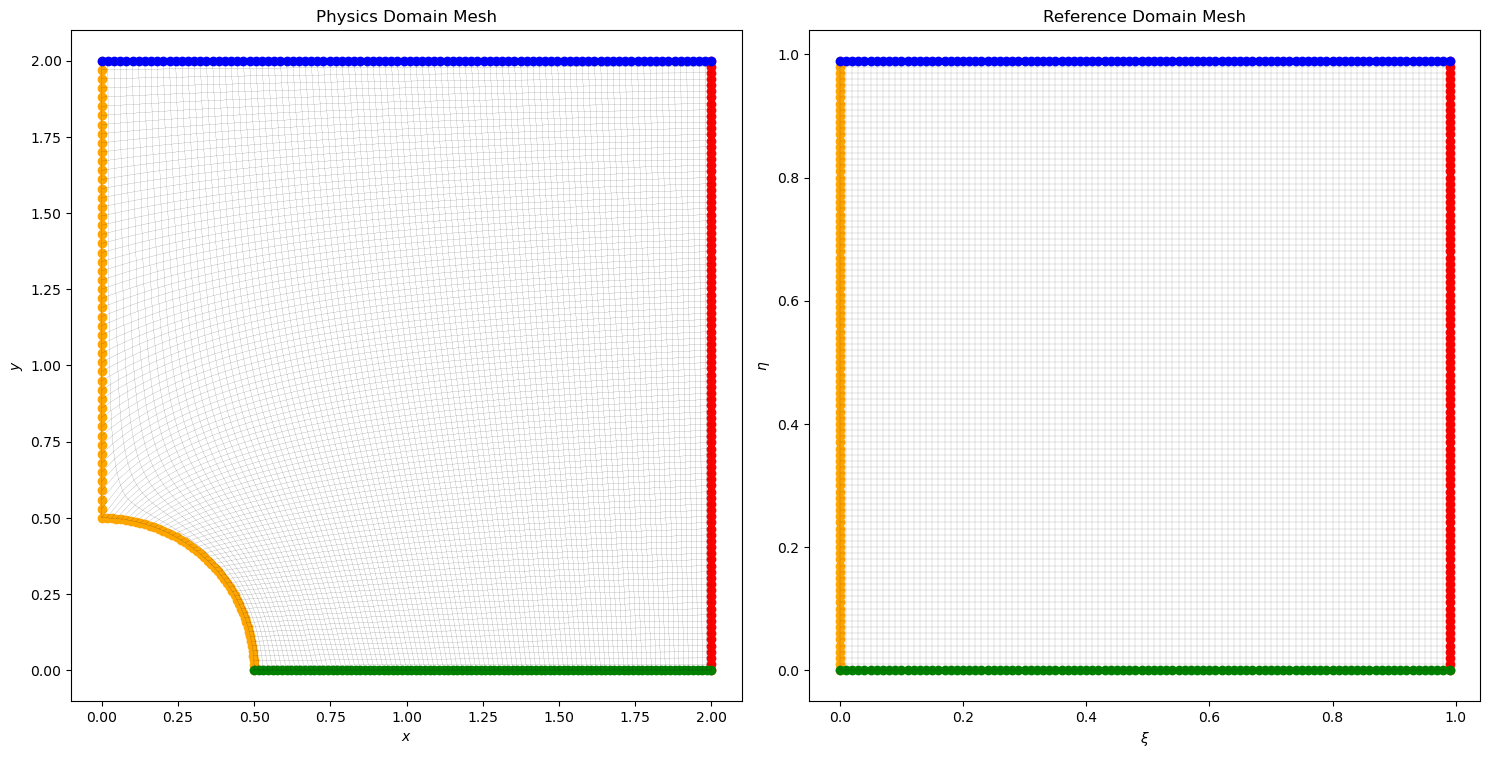

In [5]:
fig, ax = plt.subplots(1, 2,figsize=(15,10))
plotBC(ax[0],myMesh.x,myMesh.y)
plotMesh(ax[0],myMesh.x,myMesh.y)
setAxisLabel(ax[0],'p')
ax[0].set_aspect('equal')
ax[0].set_title('Physics Domain Mesh')

plotBC(ax[1],myMesh.xi,myMesh.eta)
plotMesh(ax[1],myMesh.xi,myMesh.eta)
setAxisLabel(ax[1],'r')
ax[1].set_aspect('equal')
ax[1].set_title('Reference Domain Mesh')
fig.tight_layout()

In [6]:
#save the mesh
ny=len(upX); nx=len(leftX)
data_path = f"plate_hole_quarter_{ny}x{nx}.txt"
np.savetxt(data_path, np.hstack((myMesh.x.reshape(-1, 1), myMesh.y.reshape(-1, 1))), delimiter=' ', fmt='%1.16f')

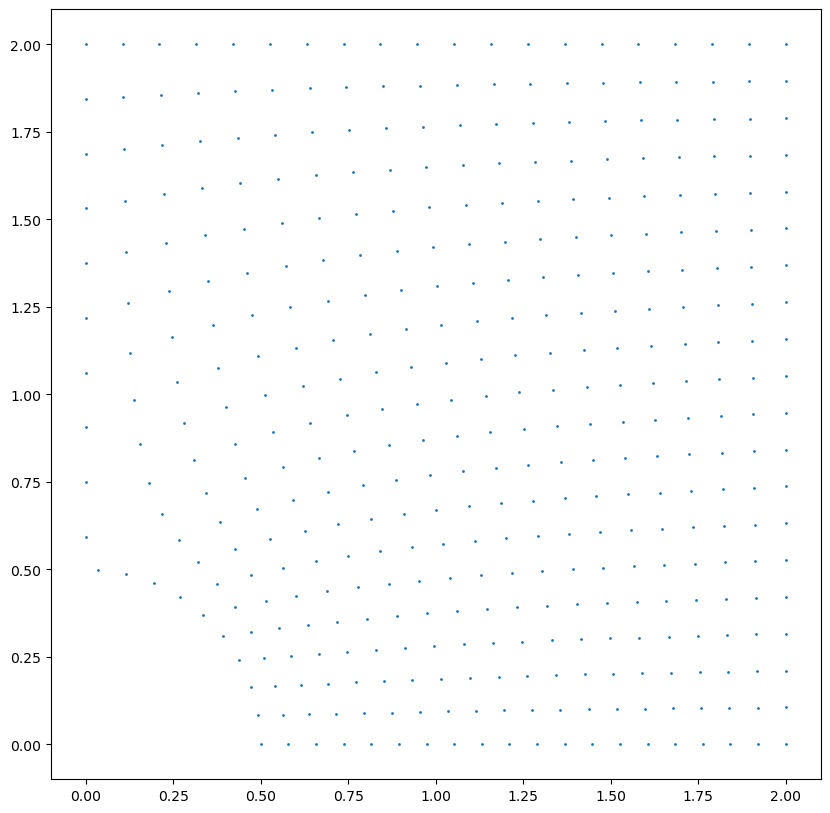

In [7]:
import jax
import jax.numpy as jnp

# Load geometry mapping
nx=100
ny=100
Xp = np.loadtxt(f"plate_hole_quarter_{nx}x{ny}.txt")

# Interpolate mapping
X_map_points = Xp[:, 0].reshape((ny, nx)).T
Y_map_points = Xp[:, 1].reshape((ny, nx)).T

def coordMap(x):
    x_pos = x[:, 0]*(nx-1)
    y_pos = x[:, 1]*(ny-1)

    x_mapped = jax.scipy.ndimage.map_coordinates(X_map_points, [x_pos, y_pos], order=1)
    y_mapped = jax.scipy.ndimage.map_coordinates(Y_map_points, [x_pos, y_pos], order=1)

    return jnp.stack((x_mapped, y_mapped), axis=1)

n_plot = 20
x_plot = np.linspace(0, 1, n_plot)
y_plot = np.linspace(0, 1, n_plot)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)
X_plot, Y_plot = X_plot.flatten(), Y_plot.flatten()
X_mapped, Y_mapped = coordMap(jnp.stack((X_plot, Y_plot), axis=1)).T

fig, ax = plt.subplots(1, 1,figsize=(10,10))
plt.scatter(X_mapped, Y_mapped, s=1)
# plt.xlim(0, x_max)
# plt.ylim(0, y_max)
ax.set_aspect('equal')

(-0.2, 0.55)

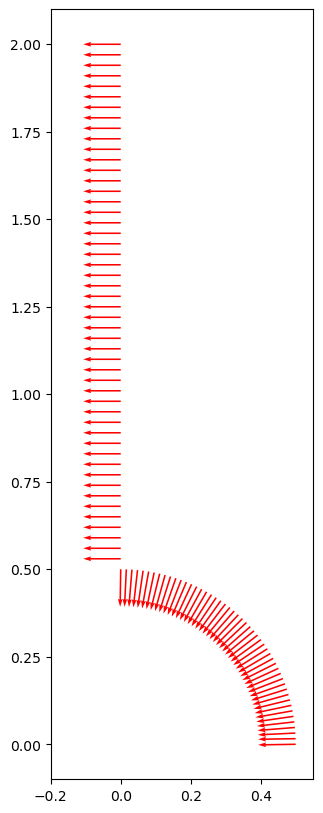

In [8]:
def coordMap(x, padding=1e-6):
    x_pos = x[0]*(nx-1)*(1-2*padding) + padding
    y_pos = x[1]*(ny-1)*(1-2*padding) + padding

    x_mapped = jax.scipy.ndimage.map_coordinates(X_map_points, [x_pos, y_pos], order=1, mode='nearest')
    y_mapped = jax.scipy.ndimage.map_coordinates(Y_map_points, [x_pos, y_pos], order=1, mode='nearest')

    return jnp.stack((x_mapped, y_mapped), axis=0)

def tensMap(tens, x):
    J = jax.jacobian(coordMap)(x)
    J_inv = jnp.linalg.inv(J)
    return tens @ J_inv

# vec1 = jnp.ones(X_mapped.shape)
# vec0 = jnp.zeros(X_mapped.shape)

# U_1 = jnp.stack((-vec1, vec0), axis=1)
# U_2 = jnp.stack((vec0, vec1), axis=1)

# U1_mapped = jax.vmap(tensMap)(U_1, jnp.stack((X_plot, Y_plot), axis=1)).squeeze()
# U2_mapped = jax.vmap(tensMap)(U_2, jnp.stack((X_plot, Y_plot), axis=1)).squeeze()

# fig, ax = plt.subplots(1, 2,figsize=(20,10))
# ax[0].quiver(X_plot, Y_plot, vec1, vec0)
# ax[0].quiver(X_plot, Y_plot, vec0, vec1)

# ax[0].quiver(X_plot, Y_plot, U1_mapped[:, 0], U1_mapped[:, 1], color='r')
# ax[0].quiver(X_plot, Y_plot, U2_mapped[:, 0], U2_mapped[:, 1], color='r')
# ax[0].set_aspect('equal')
# ax[1].quiver(X_mapped, Y_mapped, U1_mapped[:, 0], U1_mapped[:, 1])
# ax[1].quiver(X_mapped, Y_mapped, U2_mapped[:, 0], U2_mapped[:, 1])
# ax[1].set_aspect('equal')

# Sxx = jnp.zeros(X_mapped.shape)
# Syy = jnp.ones(X_mapped.shape)
# Sxy = jnp.zeros(X_mapped.shape)

# S = [Sxx, Syy, Sxy]
# S as a 2x2 matrix
# S = jnp.stack((jnp.stack((Sxx, Sxy), axis=0), jnp.stack((Sxy, Syy), axis=0)), axis=1).reshape(-1, 2, 2)

# S_mapped = jax.vmap(tensMap)(S, jnp.stack((X_plot, Y_plot), axis=1))

ngrid=100
x_left = np.zeros(ngrid)

y_left = np.linspace(0, 1, ngrid)
X_left = jnp.stack((x_left, y_left), axis=1)
X_left_mapped = jax.vmap(coordMap)(X_left)

Tx = -1*jnp.ones(x_left.shape)
Ty = jnp.zeros(x_left.shape)

T = jnp.stack((Tx, Ty), axis=1)
T_mapped = jax.vmap(tensMap)(T, X_left)

#normalize T_mapped
T_mapped = T_mapped/jnp.linalg.norm(T_mapped, axis=1).reshape(-1, 1)

fig, ax = plt.subplots(1, 1,figsize=(10,10))
ax.quiver(X_left_mapped[:, 0], X_left_mapped[:, 1], T_mapped[:, 0], T_mapped[:, 1], scale=7, color='r')
# ax.quiver(X_left[:, 0], X_left[:, 1], T_mapped[:, 0], T_mapped[:, 1], scale=8, color='r')
# ax.quiver(X_left[:, 0], X_left[:, 1], T[:, 0], T[:, 1], scale=7)
# plt.scatter(X_left_mapped[:, 0], X_left_mapped[:, 1], s=1, c=T_mapped[:, 0])
# plt.scatter(X_left[:, 0], X_left[:, 1], s=1, color='r')
ax.set_aspect('equal', 'box')
ax.set_xlim([-0.2, 0.55])
#straight line at x=0
# ax.plot([0, 0], [0, L], 'r-')

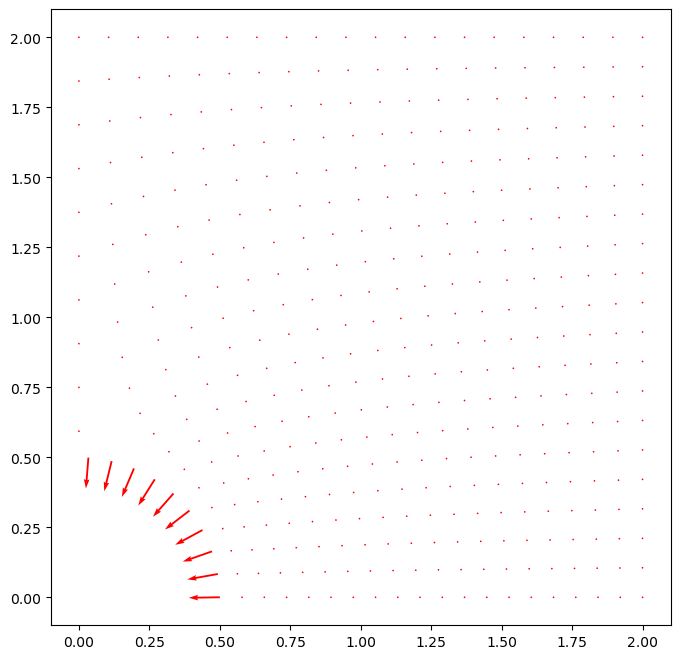

In [10]:
Tx = -1*jnp.ones(X_mapped.shape)
Ty = jnp.zeros(X_mapped.shape)

T = jnp.stack((Tx, Ty), axis=1)
T_mapped = jax.vmap(tensMap)(T, jnp.stack((X_plot, Y_plot), axis=1))
T_mapped = T_mapped/jnp.linalg.norm(T_mapped, axis=1).reshape(-1, 1)

#filter vector that are one the bottom left corner
# mask = (X_plot==0) & (Y_plot<=0.5)
mask = jnp.logical_and(X_plot==0, Y_plot<=0.5)

mask_array = jnp.stack((mask, mask), axis=1)
# T_mapped = T_mapped.at[~mask].set(jnp.array([0, 0]))
T_mapped = jnp.where(mask_array, T_mapped, jnp.zeros_like(T_mapped))
fig, ax = plt.subplots(1, 1,figsize=(8,8))
ax.quiver(X_mapped, Y_mapped, T_mapped[:, 0], T_mapped[:, 1], scale=20, color='r')


In [130]:
ngrid=100
x_left = np.zeros(ngrid)
y_left = np.linspace(0, L, ngrid)
X_left = jnp.stack((x_left, y_left), axis=1)
X_left_mapped = jax.vmap(coordMap)(X_left)

Tx = -1*jnp.ones(x_left.shape)
Ty = jnp.zeros(x_left.shape)

T = jnp.stack((Tx, Ty), axis=1)
T_mapped = jax.vmap(tensMap)(T, X_left, axis=1)

fig, ax = plt.subplots(1, 1,figsize=(10,10))
ax.quiver(X_mapped, Y_mapped, T_mapped[:, 0], T_mapped[:, 1])


ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

(400, 2, 2)
(400, 2)
(400, 2)


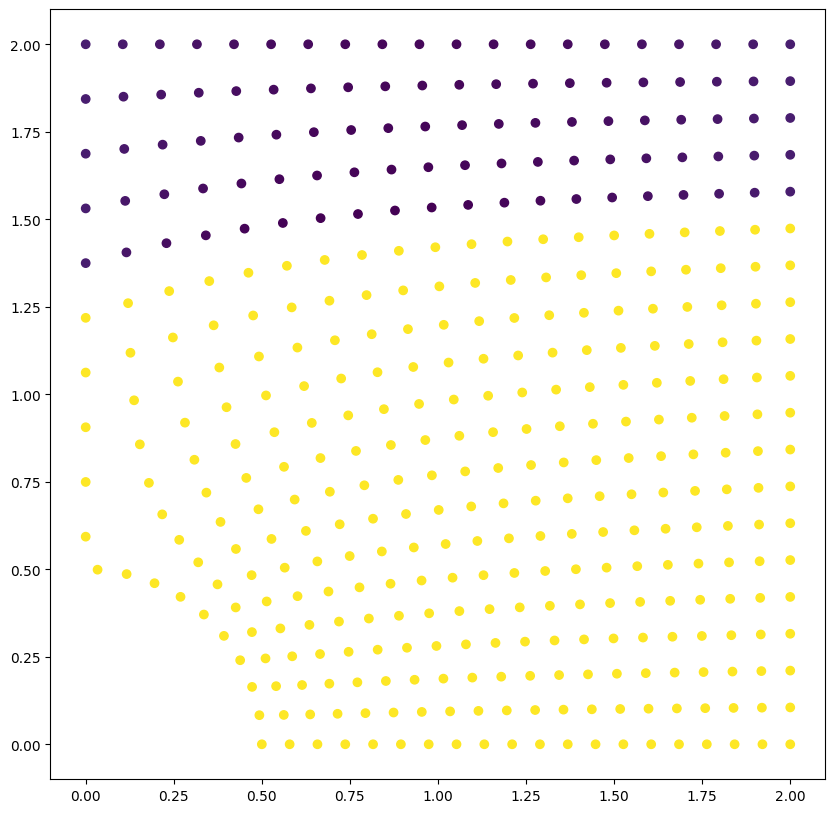

In [140]:
def tensMap(tens, x):
    J = jax.jacobian(coordMap)(x)
    J_inv = jnp.linalg.inv(J)
    return tens @ J_inv

def calcNormal(x):
    n = jnp.array([-1, 0])
    n_mapped = tensMap(n, x)
    return n_mapped/jnp.linalg.norm(n_mapped)

n = jax.vmap(calcNormal)(jnp.stack((X_plot, Y_plot), axis=1))
S = jnp.stack((jnp.stack((Sxx, Sxy), axis=0), jnp.stack((Sxy, Syy), axis=0)), axis=1).reshape(-1, 2, 2)

# S = jnp.array([[Sxx, Sxy], [Sxy, Syy]])
print(S.shape)
print(n.shape)

balance = jax.vmap(jnp.dot)(S, n)
print(balance.shape)

fig, ax = plt.subplots(1, 1,figsize=(10,10))
plt.scatter(X_mapped, Y_mapped, c=balance[:, 0])

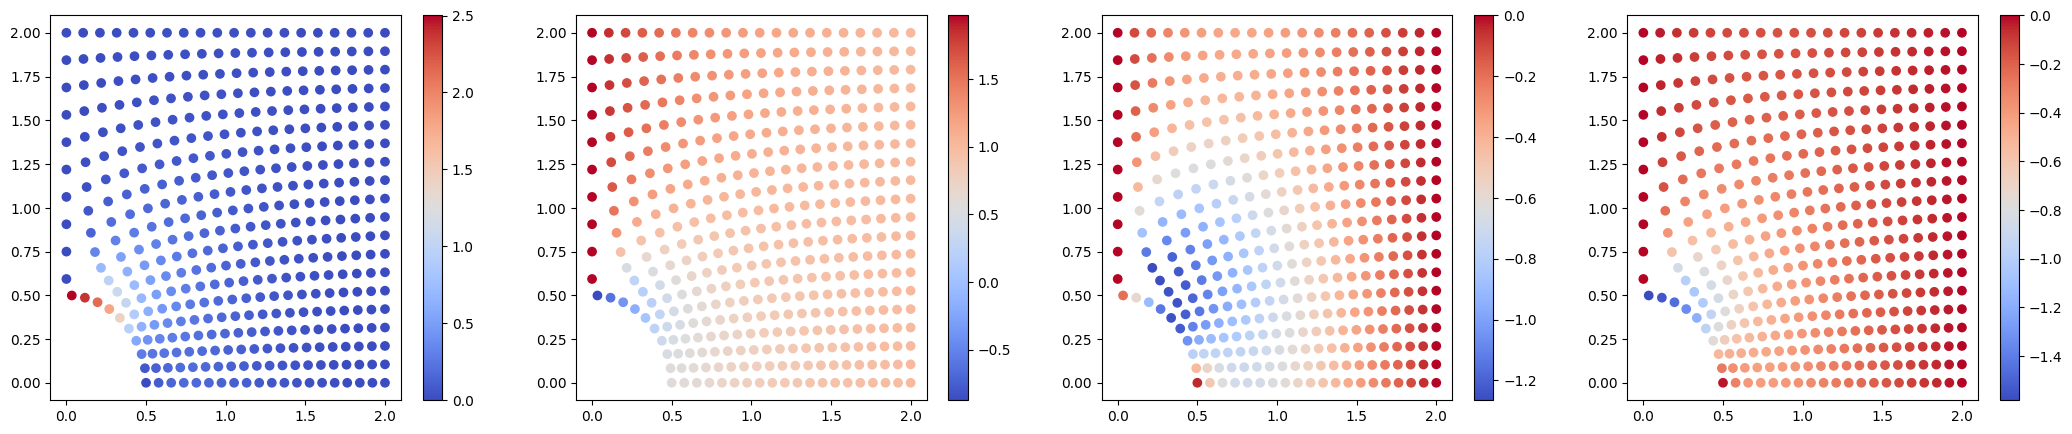

In [103]:
def tensMap(S, x):
    Sxx, Syy, Sxy = S
    Syx = Sxy
    J = jax.jacobian(coordMap)(x)

    Syx, Syy = jnp.stack((Syx, Syy), axis=0) @ J.T
    Sxx, Sxy = jnp.stack((S[0], Syx), axis=0) @ J.T 
    return [Sxx, Syy, Sxy, Syx]

Sxx = jnp.zeros(X_mapped.shape)
Syy = jnp.ones(X_mapped.shape)
Sxy = jnp.zeros(X_mapped.shape)

S = [Sxx, Syy, Sxy]
# S as a 2x2 matrix
# S = jnp.stack((jnp.stack((Sxx, Sxy), axis=0), jnp.stack((Sxy, Syy), axis=0)), axis=0).reshape(-1, 2, 2)

S_mapped = jax.vmap(tensMap)(S, jnp.stack((X_plot, Y_plot), axis=1))

fig, ax = plt.subplots(1, 4,figsize=(26,5))
im = ax[0].scatter(X_mapped, Y_mapped, c=S_mapped[0], cmap='coolwarm')
fig.colorbar(im, ax=ax[0])

im = ax[1].scatter(X_mapped, Y_mapped, c=S_mapped[1]-jnp.ones(X_mapped.shape), cmap='coolwarm')
fig.colorbar(im, ax=ax[1])

im = ax[2].scatter(X_mapped, Y_mapped, c=S_mapped[2], cmap='coolwarm')
fig.colorbar(im, ax=ax[2])

im = ax[3].scatter(X_mapped, Y_mapped, c=S_mapped[3], cmap='coolwarm')
fig.colorbar(im, ax=ax[3])

In [50]:
def tensMap(tens, x):
    J = jax.jacobian(coordMap)(x)
    return tens @ J.T

Sxx = jnp.zeros(X_mapped.shape)
Syy = jnp.ones(X_mapped.shape)
Sxy = jnp.zeros(X_mapped.shape)

# S = [Sxx, Syy, Sxy]
# S as a 2x2 matrix
S = jnp.stack((jnp.stack((Sxx, Sxy), axis=1), jnp.stack((Sxy, Syy), axis=1)), axis=2)#.reshape(-1, 2, 2)

S_mapped = jax.vmap(tensMap)(S, jnp.stack((X_plot, Y_plot), axis=1))

fig, ax = plt.subplots(1, 4,figsize=(26,5))
im = ax[0].scatter(X_mapped, Y_mapped, c=S_mapped[:, 0, 0], cmap='coolwarm')
fig.colorbar(im, ax=ax[0])

im = ax[1].scatter(X_mapped, Y_mapped, c=S_mapped[:, 1, 1]-jnp.ones(X_mapped.shape), cmap='coolwarm')
fig.colorbar(im, ax=ax[1])

im = ax[2].scatter(X_mapped, Y_mapped, c=S_mapped[:, 1, 0], cmap='coolwarm')
fig.colorbar(im, ax=ax[2])

im = ax[3].scatter(X_mapped, Y_mapped, c=S_mapped[:, 0, 1]-S_mapped[:, 1, 0], cmap='coolwarm')
fig.colorbar(im, ax=ax[3])

(2, 2, 400)

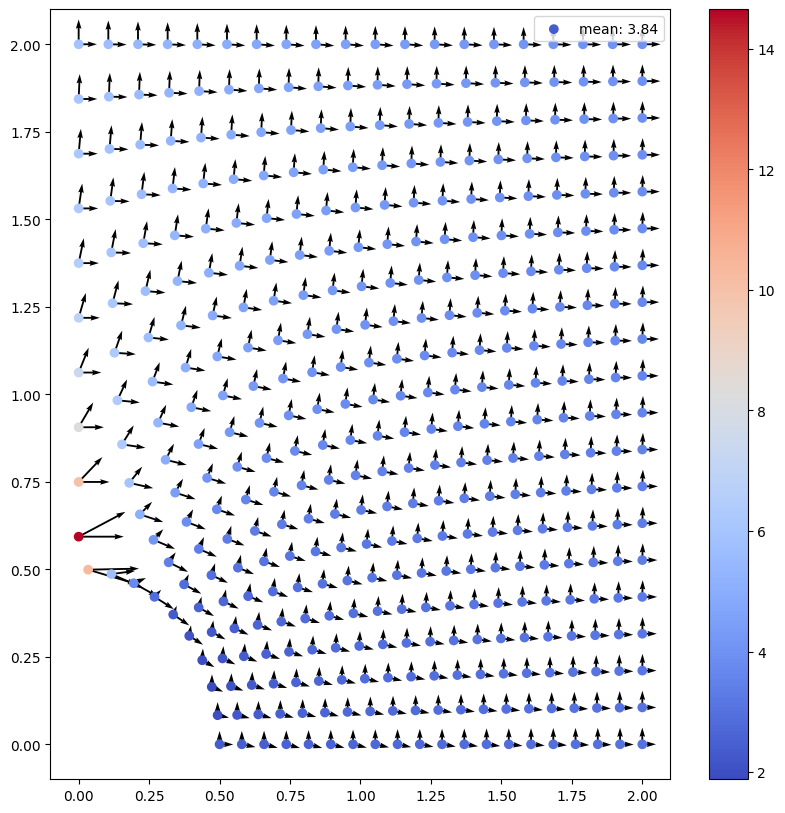

In [62]:
jacobian = jax.vmap(jax.jacobian(coordMap))(jnp.stack((X_plot, Y_plot), axis=1))
det_jacobian = jnp.linalg.det(jacobian)

fig, ax = plt.subplots(1, 1,figsize=(10,10))
plt.quiver(X_mapped, Y_mapped, jacobian[:, 0, 0], jacobian[:, 0, 1])
plt.quiver(X_mapped, Y_mapped, jacobian[:, 1, 0], jacobian[:, 1, 1])

plt.scatter(X_mapped, Y_mapped,c=det_jacobian, cmap='coolwarm', label=f"mean: {det_jacobian.mean():.2f}")
plt.colorbar()
plt.legend()

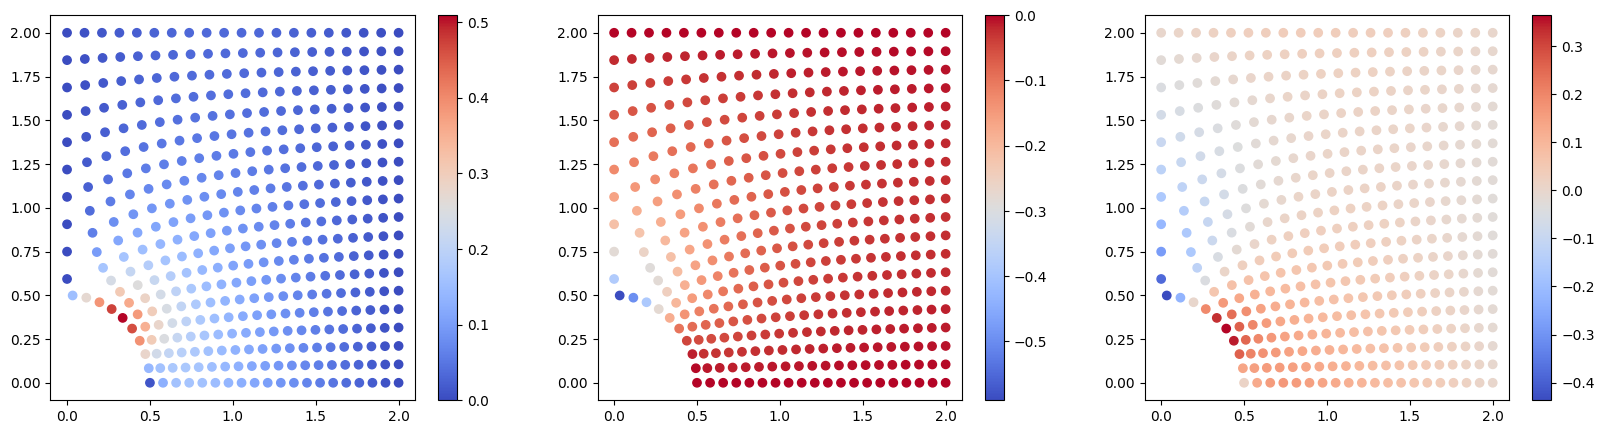

In [87]:
jacobian_inv = jnp.linalg.inv(jacobian)
det_jacobian_inv = jnp.linalg.det(jacobian_inv)

# fig, ax = plt.subplots(1, 1,figsize=(10,10))
# plt.quiver(X_mapped, Y_mapped, jacobian_inv[:, 0, 0], jacobian_inv[:, 0, 1])
# plt.quiver(X_mapped, Y_mapped, jacobian_inv[:, 1, 0], jacobian_inv[:, 1, 1])

# plt.scatter(X_mapped, Y_mapped,c=det_jacobian_inv, cmap='coolwarm', label=f"mean: {det_jacobian_inv.mean():.2f}")
# plt.colorbar()
# plt.legend()
fig, axs = plt.subplots(1, 3,figsize=(20,5))
im = axs[0].scatter(X_mapped, Y_mapped,c=jacobian_inv[:, 0,1], cmap='coolwarm')
plt.colorbar(im, ax=axs[0])
im = axs[1].scatter(X_mapped, Y_mapped,c=jacobian_inv[:, 1,0], cmap='coolwarm')
plt.colorbar(im, ax=axs[1])
im = axs[2].scatter(X_mapped, Y_mapped,c=jacobian_inv[:, 0,1]+jacobian_inv[:, 1,0], cmap='coolwarm')
plt.colorbar(im, ax=axs[2])

# plt.scatter(X_mapped, Y_mapped,c=jacobian_inv[:, 0,1]-jacobian_inv[:, 1,0], cmap='coolwarm')
# plt.colorbar()
